# Module

In [1]:
import numpy as np
import tensorflow as tf

# Dataset

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


In [4]:
print(f"x_train shape: {X_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {X_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## Data augmentation

In [5]:
transform = tf.keras.Sequential(
    [
        tf.keras.layers.Normalization(),
        tf.keras.layers.Resizing(72,72),
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(factor=0.02),
        tf.keras.layers.RandomZoom(height_factor=0.2,width_factor=0.2)
    ]
)

In [6]:
# 정규화를 위해 사진의 평균과 분산 계산
transform.layers[0].adapt(X_train)

# ViT

## MLP

In [7]:
def mlp(x, hidden_units, dropout_rate):
  for units in hidden_units:
    x = tf.keras.layers.Dense(units, activation=tf.nn.gelu)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
  return x

## Patch

In [10]:
class Patches(tf.keras.layers.Layer):
  def __init__(self, patch_size):
    super().__init__()
    self.patch_size = patch_size

  def call(self, images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images = images,
        sizes = [1, self.patch_size, self.patch_size, 1],
        strides = [1, self.patch_size, self.patch_size, 1],
        rates = [1,1,1,1],
        padding = 'VALID'
    )
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches

In [29]:
sample = tf.image.resize(tf.convert_to_tensor([X_train[0]]), size=(72,72))
sample.shape

TensorShape([1, 72, 72, 3])

In [30]:
a = tf.shape(sample)
a

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 1, 72, 72,  3], dtype=int32)>

In [31]:
batch_size = a[0]
batch_size

<tf.Tensor: shape=(), dtype=int32, numpy=1>

In [32]:
patches = tf.image.extract_patches(
    images = sample,
    sizes = [1,6,6,1],
    strides = [1,6,6,1],
    rates = [1,1,1,1],
    padding = 'VALID'
)

In [33]:
patches.shape

TensorShape([1, 12, 12, 108])

In [34]:
patch_dims = patches.shape[-1]

In [35]:
patches = tf.reshape(patches , [batch_size, -1, patch_dims])
patches.shape

TensorShape([1, 144, 108])

맨 마지막 차원의 108은 6 x 6 x 3 패치 이미지를 담고 있습니다.

이와 같은 패치가 총 144개가 존재하므로 차원이 위와 같이 나옵니다(72/6 * 72/6)

In [36]:
import matplotlib.pyplot as plt

In [37]:
print(f"Image size: 72 X 72")
print(f"Patch size: 6 X 6")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


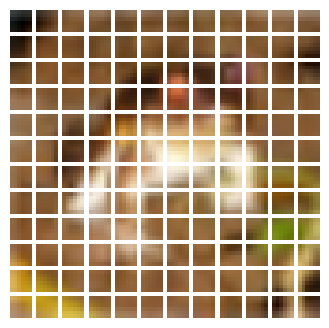

In [38]:
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (6, 6, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [52]:
class PatchEncoder(tf.keras.layers.Layer):
  def __init__(self, num_patches, projection_dim):
    super().__init__()
    self.num_patches = num_patches
    self.projection = tf.keras.layers.Dense(units=projection_dim)
    self.position_embedding = tf.keras.layers.Embedding(input_dim = num_patches, output_dim = projection_dim)

  def call(self, patch):
    positions = tf.range(start = 0, limit = self.num_patches, delta = 1)
    encoded = self.projection(patch) + self.position_embedding(positions)
    return encoded


In [53]:
num_patches = 144
projection = tf.keras.layers.Dense(64)
position_embedding = tf.keras.layers.Embedding(144,64)

In [54]:
positions = tf.range(start = 0, limit = 144, delta = 1)
positions

<tf.Tensor: shape=(144,), dtype=int32, numpy=
array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143], dtype=int32)>

start : 시작
limit : 최댓점
delta : 증가량

In [55]:
projection(patches).shape

TensorShape([None, None, 64])

In [47]:
position_embedding(positions).shape

TensorShape([144, 64])

In [49]:
# BroadCasting
encoded = projection(patches) + position_embedding(positions)
encoded.shape

TensorShape([1, 144, 64])

## 최종

In [50]:
num_patches = (72 // 6) ** 2
num_patches

144

In [57]:
inputs = tf.keras.layers.Input(shape=(32,32,3))
augmented = transform(inputs)
patches = Patches(6)(augmented)
encoded_patches = PatchEncoder(144,64)(patches)

# Transformer block
for _ in range(8):

  x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
  attention_output = tf.keras.layers.MultiHeadAttention(num_heads = 8, key_dim = 64, dropout=0.1)(x1,x1)
  x2 = tf.keras.layers.Add()([attention_output, encoded_patches])
  x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)
  x3 = mlp(x3, hidden_units = [128, 64], dropout_rate = 0.1)
  encoded_patches = tf.keras.layers.Add()([x3,x2])

# MLP layer
x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = mlp(x,hidden_units = [1024],dropout_rate=0.5)

output = tf.keras.layers.Dense(10)(x)

model = tf.keras.models.Model(inputs=inputs, outputs = output)

In [58]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 72, 72, 3)    7           ['input_3[0][0]']                
                                                                                                  
 patches_3 (Patches)            (None, None, 108)    0           ['sequential[2][0]']             
                                                                                                  
 patch_encoder_2 (PatchEncoder)  (None, 144, 64)     16192       ['patches_3[0][0]']              
                                                                                              

In [59]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc'])

In [60]:
model.fit(X_train, y_train, batch_size = 256, epochs = 100, validation_split=0.1)

Epoch 1/100
176/176 [==============================] - 69s 204ms/step - loss: 5.8628 - acc: 0.1357 - val_loss: 2.3695 - val_acc: 0.1046
Epoch 2/100
176/176 [==============================] - 35s 197ms/step - loss: 2.5744 - acc: 0.1147 - val_loss: 2.4412 - val_acc: 0.1062
Epoch 3/100
176/176 [==============================] - 35s 197ms/step - loss: 2.3630 - acc: 0.0956 - val_loss: 2.4090 - val_acc: 0.0888
Epoch 4/100
176/176 [==============================] - 35s 197ms/step - loss: 2.3630 - acc: 0.0896 - val_loss: 2.3528 - val_acc: 0.0846
Epoch 5/100
176/176 [==============================] - 35s 196ms/step - loss: 2.3524 - acc: 0.0886 - val_loss: 2.3528 - val_acc: 0.0846
Epoch 6/100
176/176 [==============================] - 35s 197ms/step - loss: 2.3569 - acc: 0.0884 - val_loss: 2.3528 - val_acc: 0.0846
Epoch 7/100
176/176 [==============================] - 35s 197ms/step - loss: 2.3524 - acc: 0.0896 - val_loss: 2.3528 - val_acc: 0.0846
Epoch 8/100
176/176 [===========================

KeyboardInterrupt: ignored

In [61]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 7s 22ms/step - loss: 2.3026 - acc: 0.1046


[2.30259108543396, 0.10459999740123749]